## Building basic likelihoods

In [1]:
import sys
import os
import glob
import importlib

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

In [11]:
import discovery.metamatrix as mm
import discovery.metamath as mh

Read nanograv pulsars

In [6]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

In [7]:
psr = allpsrs[0]

## Graph tests

Simple graph, all constants, will be reduced to constant.

In [742]:
@mm.graph
def sumtwo(graph, a, b):
    a2 = 2 * a
    b3 = 3 * b
    result = a2 + b3

In [743]:
mm.print_graph(sumtwo(1, 2))

a: const = 1
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1


In [744]:
mm.print_graph(mm.fold_constants(sumtwo(1, 2)))

a: const = 1
b: const = 2
n0: const = 2
n1: const = 6
n2: const = 8


In [745]:
mm.print_graph(mm.prune_graph(mm.fold_constants(sumtwo(1, 2))))

n2: const = 8


In [746]:
mm.func(sumtwo(1, 2))()

Array(8, dtype=int64, weak_type=True)

Now with one argument, will be reduced partially, and create a function of one argument.

In [747]:
mm.print_graph(sumtwo(None, 2))

a: arg
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1


In [748]:
mm.print_graph(mm.fold_constants(sumtwo(None, 2)))

a: arg
b: const = 2
n0: node(a) = 2 * a
n1: const = 6
n2: node(n0, n1) = n0 + n1


In [749]:
mm.print_graph(mm.prune_graph(mm.fold_constants(sumtwo(None, 2))))

a: arg
n0: node(a) = 2 * a
n1: const = 6
n2: node(n0, n1) = n0 + n1


In [750]:
mm.func(sumtwo(None, 2))(5)

Array(16, dtype=int64, weak_type=True)

One of the inputs is a function. Everything folded.

In [751]:
def double(a, params={}):
    return 2.5 * a
double.args = ['a']

In [752]:
@mm.graph
def sumtwo(graph, a, b, f):
    result = f(a) + 3 * b

In [753]:
mm.print_graph(sumtwo(2, 3, double))

a: const = 2
b: const = 3
f: func = <function double at 0x40e20b740>
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1


In [754]:
mm.print_graph(mm.fold_constants(sumtwo(2, 3, double)))

a: const = 2
b: const = 3
f: func = <function double at 0x40e20b740>
n0: const = 5.0
n1: const = 9
n2: const = 14.0


In [755]:
mm.print_graph(mm.prune_graph(mm.fold_constants(sumtwo(2, 3, double))))

n2: const = 14.0


One of the inputs is a function, cannot be evaluated immediately.

In [756]:
mm.print_graph(mm.prune_graph(mm.fold_constants(sumtwo(None, 3, double))))

a: arg
f: func = <function double at 0x40e20b740>
n0: node(f, a) = f(a)
n1: const = 9
n2: node(n0, n1) = n0 + n1


In [757]:
mm.func(sumtwo(None, 3, double))(4)

Array(19., dtype=float64, weak_type=True)

One of the inputs is a function that depends on params, won't be evaluated immediately.

In [758]:
def double(a, params):
    return params['m'] * a
double.args = ['a']
double.params = ['m']

In [759]:
mm.print_graph(sumtwo(2, 3, double))

a: const = 2
b: const = 3
f: func = <function double at 0x40e20bce0>
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1


In [760]:
mm.print_graph(mm.fold_constants(sumtwo(2, 3, double)))

a: const = 2
b: const = 3
f: func = <function double at 0x40e20bce0>
n0: node(f, a) = f(a)
n1: const = 9
n2: node(n0, n1) = n0 + n1


In [761]:
mm.print_graph(mm.prune_graph(mm.fold_constants(sumtwo(2, 3, double))))

a: const = 2
f: func = <function double at 0x40e20bce0>
n0: node(f, a) = f(a)
n1: const = 9
n2: node(n0, n1) = n0 + n1


In [762]:
mm.func(sumtwo(2, 3, double)).params

['m']

In [763]:
mm.func(sumtwo(2, 3, double))(params={'m': 3})

Array(15, dtype=int64, weak_type=True)

## Discovery components

Simple noise solver

In [765]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

All constants

In [766]:
yvec = psr.residuals
Nvec = ds.makenoise_measurement(psr, noisedict=psr.noisedict).N

In [767]:
Nsolve = noisesolve(yvec, Nvec)

In [768]:
mm.print_graph(Nsolve)

y: const = array(shape=(7758,), dtype=float64)
N: const = array(shape=(7758,), dtype=float64)
n0: node(N, y) = solve(N, y)


In [769]:
mm.print_graph(mm.prune_graph(mm.fold_constants(Nsolve)))

n0: const = array(shape=(7758,), dtype=float64), array(shape=(), dtype=float64)


First empty argument

In [770]:
Nsolve = noisesolve(None, Nvec)

In [771]:
mm.print_graph(mm.prune_graph(mm.fold_constants(Nsolve)))

y: arg
N: const = array(shape=(7758,), dtype=float64)
n0: node(N, y) = solve(N, y)


In [772]:
mm.func(Nsolve).params

[]

In [773]:
mm.func(Nsolve)(yvec)

(Array([-924684.05643357,  -15209.00619106, -256184.91074607, ...,
         457218.89618558, 3758690.70368335, 1397786.82265916],      dtype=float64),
 Array(-209930.62020633, dtype=float64))

Works also for a matrix

In [774]:
Fmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).F

In [775]:
mm.func(Nsolve)(Fmat)

(Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.05907192e+11],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.94299584e+12],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.57914432e+11]], dtype=float64),
 Array(-209930.62020633, dtype=float64))

What if N is a function?

In [776]:
Nfunc = ds.makenoise_measurement(psr).getN

In [777]:
Nfunc.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [778]:
Nsolve = noisesolve(yvec, Nfunc)

In [779]:
mm.print_graph(mm.prune_graph(mm.fold_constants(Nsolve)))

y: const = array(shape=(7758,), dtype=float64)
N: func = <function makenoise_measurement.<locals>.getnoise at 0x3d82328e0>
n0: node(N, y) = solve(N, y)


In [780]:
mm.func(Nsolve).params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [781]:
mm.func(Nsolve)(params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([ -76508.64853174,  -13787.42560781,  -38014.5492617 , ...,
         470538.49473593, 3713291.61543291, 1426449.03186325],      dtype=float64),
 Array(-207095.72133187, dtype=float64))

In [782]:
Nsolve = noisesolve(None, Nfunc)

In [783]:
mm.print_graph(mm.prune_graph(mm.fold_constants(Nsolve)))

y: arg
N: func = <function makenoise_measurement.<locals>.getnoise at 0x3d82328e0>
n0: node(N, y) = solve(N, y)


In [784]:
mm.func(Nsolve).params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [785]:
mm.func(Nsolve)(yvec, params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([-1067985.5206509 ,   -16545.80953545,  -287263.80033425, ...,
          569309.84582354,  4678167.55704747,  1740315.15266447],      dtype=float64),
 Array(-210895.26040732, dtype=float64))

Prior inverse

In [786]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [787]:
Pmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).Phi.N

In [788]:
Pinv = noiseinv(Pmat)

In [789]:
mm.print_graph(mm.fold_constants(Pinv))

P: const = array(shape=(360,), dtype=float64)
n0: const = array(shape=(360, 360), dtype=float64), array(shape=(), dtype=float64)


In [790]:
mm.func(Pinv).params

[]

In [791]:
mm.func(Pinv)()

(Array([[3.94679176e+13, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.94679176e+13, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.94679176e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.92015299e+13, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.92015299e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.92015299e+13]], dtype=float64),
 Array(-10482.98152208, dtype=float64))

In [792]:
Pfunc = ds.makegp_ecorr(psr).Phi.getN

In [793]:
Pfunc.params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [794]:
Pinv = noiseinv(Pfunc)

In [795]:
mm.print_graph(mm.prune_graph(mm.fold_constants(Pinv)))

P: func = <function makegp_ecorr.<locals>.getphi at 0x3e87351c0>
n0: node(P) = inv(P)


In [796]:
mm.func(Pinv).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [797]:
mm.func(Pinv)(params=ds.sample_uniform(mm.func(Pinv).params))

(Array([[1.07556672e+15, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.07556672e+15, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.07556672e+15, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.09448888e+15, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 4.09448888e+15, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 4.09448888e+15]], dtype=float64),
 Array(-12113.61018479, dtype=float64))

Woodbury

In [824]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [825]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [826]:
@mm.graph
def woodbury(graph, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = (Pm + FtNmF).factor()

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ cf(FtNmy)) - 0.5 * (lN + lP + lS)

In [834]:
Nsolve = noisesolve(None, Nvec)
mm.print_graph(Nsolve)

y: arg
N: const = array(shape=(7758,), dtype=float64)
n0: node(N, y) = solve(N, y)


In [835]:
Pinv = noiseinv(Pfunc)
mm.print_graph(Pinv)

P: func = <function makegp_ecorr.<locals>.getphi at 0x3e87351c0>
n0: node(P) = inv(P)


In [836]:
onewood = woodbury(yvec, mm.func(Nsolve), Fmat, mm.func(Pinv))

In [837]:
mm.print_graph(mm.prune_graph(mm.fold_constants(onewood)))

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x3c199e7a0>>
n2: const = array(shape=(), dtype=float64)
n4: const = array(shape=(360,), dtype=float64)
n9: const = array(shape=(360, 360), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array(shape=(), dtype=float64)
n18: const = array(shape=(360,), dtype=float64)
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25


In [838]:
mm.func(onewood)(params = ds.sample_uniform(mm.func(onewood).params))

Array(98559.39376412, dtype=float64)

## Discovery likelihood

#### Measurement noise only

In [1426]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement_simple(psr)])

In [839]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [840]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [841]:
@mm.graph
def normal(g, y, Nsolve):
    Nmy, lN = Nsolve(y).split()
    logp = -0.5 * (y.T @ Nmy) - 0.5 * lN

In [842]:
class NoiseMatrix:
    def __init__(self, N):
        self.N = N

    @property
    def make_solve(self):
        return mm.func(noisesolve(None, self.N))    

    @property
    def make_inv(self):
        return mm.func(noiseinv(self.N))

In [843]:
ds.signals.matrix.NoiseMatrix1D_novar = NoiseMatrix
ds.signals.matrix.NoiseMatrix1D_var = NoiseMatrix

In [844]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [845]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

n7: const = array(shape=(), dtype=float64)


In [846]:
mm.func(graph)()

Array(96686.81011374, dtype=float64)

In [847]:
N = ds.makenoise_measurement(psr)
graph = normal(psr.residuals, N.make_solve)

In [848]:
N.make_solve.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [849]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

y: const = array(shape=(7758,), dtype=float64)
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x43712e980>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = split(n0)[0]
n2: node(n0) = split(n0)[1]
n3: const = array(shape=(7758,), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n5: node(n4) = -0.5 * n4
n6: node(n2) = 0.5 * n2
n7: node(n5, n6) = n5 - n6


In [850]:
mm.func(graph).params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [851]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(90546.10232252, dtype=float64)

#### Add ECORR noise

In [852]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr),
#                          ds.makegp_ecorr(psr)])

In [853]:
@mm.graph
def woodbury(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)    
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.factor(Pm + FtNmF)

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ cf(FtNmy)) - 0.5 * (lN + lP + lS)

In [854]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [855]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
egp = ds.makegp_ecorr(psr)
graph = woodbury(psr.residuals, N.make_solve, egp.F, egp.Phi.make_inv)

In [856]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x3ea6814e0>>
n2: const = array(shape=(), dtype=float64)
n4: const = array(shape=(360,), dtype=float64)
n9: const = array(shape=(360, 360), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x393043ce0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array(shape=(), dtype=float64)
n18: const = array(shape=(360,), dtype=float64)
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25


In [857]:
mm.func(graph).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [858]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(96796.92856542, dtype=float64)

#### Constant GP + variable GP

In [859]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [860]:
importlib.reload(mm)

<module 'discovery.metamatrix' from '/Users/vallis/Documents/discovery/src/discovery/metamatrix.py'>

In [861]:
@mm.graph
def woodburysolve(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.factor(Pm + FtNmF)

    solve = Nmy - NmF @ cf(FtNmy)
    ld = lN + lP + lS

    result = g.pair(solve, ld)

In [862]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

In [863]:
graph1 = woodburysolve(None, N.make_solve, tgp.F, tgp.Phi.make_inv)

In [864]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph1)))

y: arg
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4370cd620>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(shape=(166, 7758), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n6: const = array(shape=(7758, 166), dtype=float64)
n11: const = array(shape=(), dtype=float64)
n14: const = <function cholesky_factor.<locals>.solver at 0x447864d60>
n15: const = array(shape=(), dtype=float64)
n16: node(n14, n4) = n14(n4)
n17: node(n6, n16) = n6 @ n16
n18: node(n1, n17) = n1 - n17
n19: node(n2, n11) = n2 + n11
n20: node(n19, n15) = n19 + n15
n21: node(n18, n20) = <function GraphBuilder.pair.<locals>.<lambda> at 0x43342c900>


In [865]:
graph2 = woodbury(yvec, mm.func(graph1), rgp.F, rgp.Phi.make_inv)

In [866]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph2)))

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x395d5d080>>
n2: const = array(shape=(), dtype=float64)
n4: const = array(shape=(60,), dtype=float64)
n9: const = array(shape=(60, 60), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x38e0940e0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array(shape=(), dtype=float64)
n18: const = array(shape=(60,), dtype=float64)
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25


In [867]:
mm.func(graph2).params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [868]:
mm.func(graph2)(params=ds.sample_uniform(mm.func(graph2).params))

Array(89903.63134199, dtype=float64)

### Full single likelihood

In [869]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_ecorr(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [871]:
@mm.graph
def concat(g, a, b):
    result = g.node(lambda x, y: jnp.hstack([x, y]), [a, b])

In [872]:
import functools

class CompoundGP:
    def __init__(self, gplist):
        self.gplist = gplist

    @property
    def F(self):
        return functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.F for gp in self.gplist])
    
    @property
    def Phi(self):
        # won't work for 2D priors
        N = functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.Phi.N for gp in self.gplist]) 
        return NoiseMatrix(N)

In [873]:
@mm.graph
def delay(g, y, d):
    result = y - d

In [874]:
def CompoundDelay(residuals, delays):
    return functools.reduce(lambda x, y: mm.func(delay(x, y)), [residuals, *delays])

#### Clean example

In [875]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)

egp = ds.makegp_ecorr(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
cgp = CompoundGP([egp, tgp])

graph1 = woodburysolve(None, N.make_solve, cgp.F, cgp.Phi.make_inv)

cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']
yd = CompoundDelay(yvec, [ds.makedelay(psr, ds.makedelay_binary(pulsarterm=True), common=cwcommon, name='cw')])

rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

graph2 = woodbury(yd, mm.func(graph1), rgp.F, rgp.Phi.make_inv)

logp = mm.func(graph2)

In [876]:
mm.print_graph(graph2, simplify=True)

y: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4370cc400>>
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x447ee3ba0>>
Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x447ee3920>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(shape=(60, 7758), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n9: const = array(shape=(60, 60), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x383a177e0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = <function Sym.T.<locals>.<lambda> at 0x447ef8e00>
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = <function Sym.T.<locals>.<lambda> at 0x447ef8f40>
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n1

In [877]:
p0 = ds.sample_uniform(logp.params)

In [878]:
p0

{'B1855+09_cw_phi_psr': 1.411928033421281,
 'B1855+09_rednoise_gamma': 0.3375543574402363,
 'B1855+09_rednoise_log10_A': -15.03119920193601,
 'cw_cosinc': 0.5033299616673554,
 'cw_log10_f0': -8.499182894688783,
 'cw_log10_h0': -14.928982381721593,
 'cw_phi_earth': 6.023302048435835,
 'cw_psi': 0.14147652042076786,
 'cw_ra': 0.9348743543830029,
 'cw_sindec': -0.4938450071370477}

In [879]:
logp(params=ds.sample_uniform(p0))

Array(76806.82934148, dtype=float64)

## Standard tests

In [1265]:
import discovery.metamatrix as mm
import discovery.metamath as mh

(For debugging)

In [22]:
importlib.reload(mm)
importlib.reload(mh)
importlib.reload(ds.likelihood)
importlib.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

Monkey patching

In [23]:
ds.matrix.NoiseMatrix1D_novar = mh.NoiseMatrix
ds.matrix.NoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.NoiseMatrix2D_var = mh.NoiseMatrix

ds.matrix.WoodburyKernel = mh.WoodburyKernel
ds.matrix.CompoundGP = mh.CompoundGP
ds.matrix.CompoundDelay = mh.CompoundDelay

ds.matrix.VectorNoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.VectorWoodburyKernel_varP = mh.VectorWoodburyKernel
ds.matrix.VectorCompoundGP = mh.CompoundGP

### Single pulsar likelihood

#### Measurement noise only, no backends

In [1487]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement_simple(psr)])

What are the active parameters?

In [1488]:
m.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

Sample random values from their priors

In [1489]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_efac': 0.9968548546356493,
 'B1855+09_log10_t2equad': -5.248838978980659}

Evaluate the likelihood

In [1490]:
m.logL(p0)

Array(92528.52340107, dtype=float64)

Try compiled version, grad

In [1491]:
jax.jit(m.logL)(p0)

Array(92528.52340107, dtype=float64)

In [1492]:
jax.grad(m.logL)(p0)

{'B1855+09_efac': Array(-6512.82297895, dtype=float64, weak_type=True),
 'B1855+09_log10_t2equad': Array(-13779.3890528, dtype=float64, weak_type=True)}

#### Measurement noise only, nanograv backends, free parameters

In [1493]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr)])

In [1494]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [1495]:
p0 = ds.sample_uniform(m.logL.params)

In [1496]:
m.logL(p0)

Array(91579.70474092, dtype=float64)

#### Measurement noise only, nanograv backends, parameters from noisedict

In [1497]:
psr.noisedict

{'B1855+09_430_ASP_efac': 1.115935306813982,
 'B1855+09_430_ASP_log10_t2equad': -7.564164330699591,
 'B1855+09_430_PUPPI_efac': 1.000049037085653,
 'B1855+09_430_PUPPI_log10_t2equad': -6.572540211467256,
 'B1855+09_L-wide_ASP_efac': 1.043114017270374,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.517929916655293,
 'B1855+09_L-wide_PUPPI_efac': 1.1118432332882,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -7.755603780476984,
 'B1855+09_430_ASP_log10_ecorr': -6.798122106550257,
 'B1855+09_430_PUPPI_log10_ecorr': -5.6989064141929715,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.120457109433745,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641667916624413,
 'B1855+09_red_noise_log10_A': -13.940953818371378,
 'B1855+09_red_noise_gamma': -3.68432133461766}

In [1498]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict)])

In [1499]:
m.logL.params

[]

In [1500]:
m.logL({})

Array(96686.81011374, dtype=float64)

In [1501]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(96686.81011374, dtype=float64), {})

#### Add ECORR noise (GP), free params

In [1502]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr)])

In [1503]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [1504]:
p0 = ds.sample_uniform(m.logL.params)

In [1505]:
m.logL(p0)

Array(94480.5615698, dtype=float64)

In [1506]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(94480.5615698, dtype=float64),
 {'B1855+09_430_ASP_efac': Array(149.50090731, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_ecorr': Array(-172.44334992, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_t2equad': Array(0.02044358, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_efac': Array(727.75761153, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_ecorr': Array(0.262936, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_t2equad': Array(0.0373424, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_efac': Array(7160.1616756, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_ecorr': Array(4493.33771353, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_t2equad': Array(26.78260095, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_efac': Array(-2441.36868373, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_log10_ecorr': Array(142.52541455, dtype=float64, weak_type=True),
  'B1855+09_L-wide_

#### Add ECORR noise (GP), noisedict params

In [1507]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict)])

In [1508]:
m.logL.params

[]

In [1509]:
m.logL({})

Array(100267.11920383, dtype=float64)

In [1510]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(100267.11920383, dtype=float64), {})

#### Add timing model

In [1611]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True)])

In [1612]:
m.logL.params

[]

In [1613]:
m.logL({})

Array(90998.49655392, dtype=float64)

In [1514]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(90998.49655392, dtype=float64), {})

#### Add red noise (powerlaw)

In [8]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [1786]:
m.logL.params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [1787]:
p0 = ds.sample_uniform(m.logL.params)

In [1788]:
m.logL(p0)

Array(91090.24272337, dtype=float64)

In [1751]:
jlogl = jax.jit(m.logL)

In [1752]:
jlogl(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(90999.10105398, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.61960907, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(2.76025984, dtype=float64, weak_type=True)})

In [1743]:
%timeit jlogl(p0).block_until_ready()

34.2 μs ± 168 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


##### What the graphs would look like

In [25]:
y = psr.residuals
n = ds.makenoise_measurement(psr, psr.noisedict)
fgp = mh.CompoundGP([ds.makegp_ecorr(psr, psr.noisedict), ds.makegp_timing(psr, svd=True)])
vgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

In [26]:
w1 = mh.woodbury(None, n.make_solve, fgp.F, fgp.Phi.make_inv)

In [27]:
w2 = mh.woodbury(y, mm.func(w1, outputs='solve'), vgp.F, vgp.Phi.make_inv)

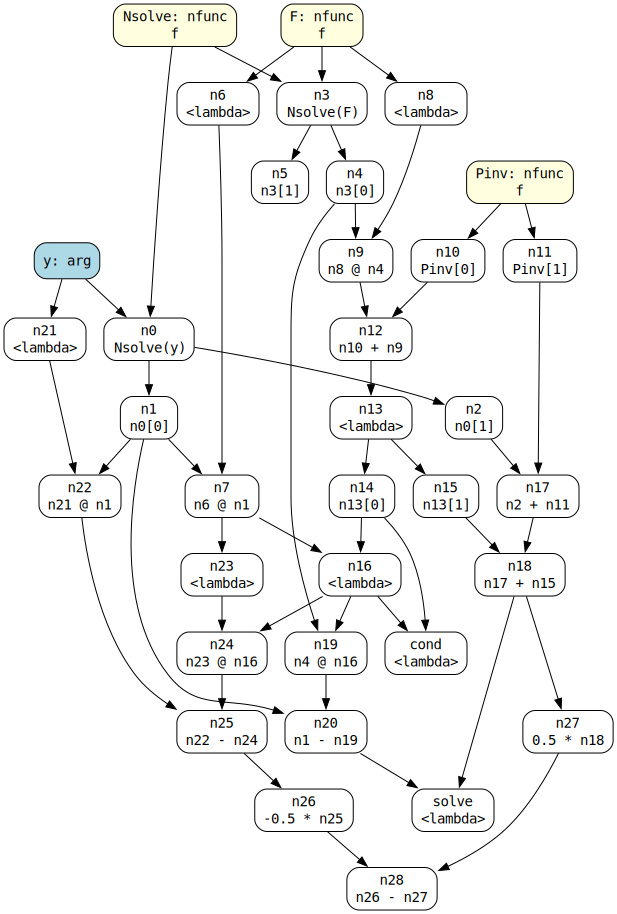

In [29]:
mm.visualize_graph(w1, simplify=False, outputs='solve')

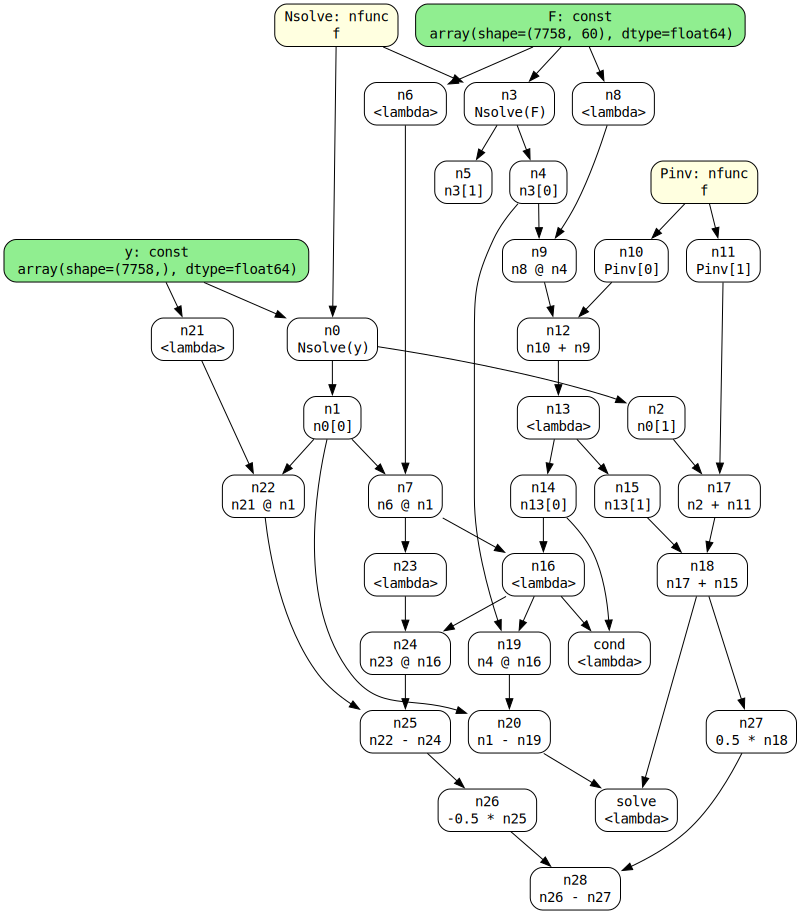

In [32]:
mm.visualize_graph(w2, simplify=False, outputs='solve')

#### Add red noise (powerlaw, fixed gamma)

In [1654]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.partial(ds.powerlaw, gamma=4.33), components=30, name='rednoise')])

In [1655]:
m.logL.params

['B1855+09_rednoise_log10_A']

In [1656]:
p0 = ds.sample_uniform(m.logL.params)

In [1657]:
m.logL(p0)

Array(91089.87098512, dtype=float64)

In [1627]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(91083.66166173, dtype=float64),
 {'B1855+09_rednoise_log10_A': Array(-27.92933017, dtype=float64, weak_type=True)})

Try out `sample_conditional`, obtained by a shortening of the `woodbury` graph.

In [1628]:
mm.print_graph(mh.woodbury(m.y, m.N.N.make_solve, m.N.F, m.N.P.make_inv), simplify=True)

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4e1fa6c00>>
n2: const = array(shape=(), dtype=float64)
n6: const = array(shape=(60,), dtype=float64)
n8: const = array(shape=(60, 60), dtype=float64)
n9: node(Pinv) = Pinv[0]
n10: node(Pinv) = Pinv[1]
n11: node(n9, n8) = n9 + n8
n12: node(n11) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x4e1fef2e0>
n13: node(n12) = n12[0]
n14: node(n12) = n12[1]
n15: node(n13, n6) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x4e1fefba0>
n16: node(n2, n10) = n2 + n10
n17: node(n16, n14) = n16 + n14
n21: const = array(shape=(), dtype=float64)
n22: const = array(shape=(60,), dtype=float64)
n23: node(n22, n15) = n22 @ n15
n24: node(n21, n23) = n21 - n23
n25: node(n24) = -0.5 * n24
n26: node(n17) = 0.5 * n17
n27: node(n25, n26) = n25 - n26


In [1629]:
mm.print_graph(mh.woodbury(m.y, m.N.N.make_solve, m.N.F, m.N.P.make_inv), simplify=True, outputs='cond')

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4e1fa6b60>>
n6: const = array(shape=(60,), dtype=float64)
n8: const = array(shape=(60, 60), dtype=float64)
n9: node(Pinv) = Pinv[0]
n11: node(n9, n8) = n9 + n8
n12: node(n11) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x4e1fefb00>
n13: node(n12) = n12[0]
n15: node(n13, n6) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x4e40340e0>
cond: node(n15, n13) = <function GraphBuilder.pair.<locals>.<lambda> at 0x4e40342c0>


In [1630]:
cond = m.conditional

In [1631]:
cond(p0)

(Array([-2.00280545e-07, -1.73763389e-06, -2.64380990e-08, -4.10111634e-07,
         2.73416220e-07,  3.95932060e-07, -2.82303463e-07,  1.88950700e-07,
        -1.15939873e-07, -6.86114158e-08,  9.24299636e-08,  5.01575452e-09,
         3.67662358e-08,  5.06742662e-08, -2.58809739e-08,  5.33827028e-08,
        -2.47850354e-08, -2.07705383e-08, -1.67823517e-08,  1.66782019e-08,
        -1.02698392e-08, -1.59195313e-08, -5.71524112e-09, -8.44929849e-09,
         1.42869031e-09,  4.80811087e-09, -6.06745758e-09,  3.58148972e-09,
         1.02342021e-09, -3.49527458e-10,  8.06652277e-10,  4.91164956e-10,
         3.72167613e-09,  4.00201538e-09,  2.85395354e-09,  4.01804060e-10,
         3.93672833e-09,  1.77622354e-09,  1.39052983e-09,  4.81777355e-09,
         1.80136265e-09,  5.11690790e-09, -3.12065918e-10,  2.31546591e-10,
        -3.10044973e-10,  7.00344314e-10,  2.05183959e-09, -9.99256383e-11,
         1.45381673e-10, -1.56202125e-09,  4.72425123e-10, -6.76702054e-10,
         4.4

In [1666]:
scond = m.sample_conditional

In [1667]:
scond(jax.random.PRNGKey(0), p0)

(Array([4146024105,  967050713], dtype=uint32),
 {'B1855+09_rednoise_coefficients(60)': Array([-4.43922170e-07, -1.56257363e-06,  6.22292843e-08, -2.69580772e-07,
          8.51991296e-08,  2.17029347e-07, -5.72493124e-08,  1.36721617e-08,
         -2.97145809e-08,  2.96723374e-08, -1.00956022e-08,  3.38835619e-08,
          9.87680722e-09,  2.70740311e-08, -8.87873769e-09, -9.02405413e-09,
          1.98141473e-09, -4.58685726e-09, -2.88417432e-09,  1.60317211e-08,
         -1.45778442e-08, -1.98427059e-09, -4.10516697e-09, -1.48712195e-09,
         -1.93829489e-09,  2.12799265e-09, -2.67517983e-09,  4.59046262e-09,
         -5.38758957e-10,  3.51973983e-10,  4.01093169e-09,  2.43597681e-09,
         -3.10620528e-10, -4.21162511e-11, -1.12205424e-09, -4.82498433e-10,
         -6.56475833e-10,  1.61691310e-09,  8.62227170e-10, -1.32400130e-10,
          1.03388348e-10, -1.90058633e-09,  3.11173766e-09,  1.69983873e-10,
         -3.10494935e-09,  5.34681594e-10, -3.29611285e-09,  5.5548

Coefficient likelihood

In [1658]:
clogl = m.clogL

In [1659]:
clogl.params

['B1855+09_rednoise_coefficients(60)', 'B1855+09_rednoise_log10_A']

In [1669]:
clogl({**p0, **scond(jax.random.PRNGKey(0), p0)[1]})

Array(92214.72331, dtype=float64)

#### Add red noise (free spectrum)

In [1531]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.freespectrum, components=30, name='rednoise')])

In [1532]:
m.logL.params

['B1855+09_rednoise_log10_rho(30)']

In [1533]:
p0 = {'B1855+09_rednoise_log10_rho(30)': 1e-6 * np.random.randn(30)}

In [1534]:
m.logL(p0)

Array(90205.41580559, dtype=float64)

TO DO - Can this be correct?

In [1535]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(90205.41580559, dtype=float64),
 {'B1855+09_rednoise_log10_rho(30)': Array([-4.60516845, -4.60517007, -4.60517016, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517018, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517019, -4.60517018, -4.60517014,
         -4.60517013, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],      dtype=float64)})

### Multiple pulsars

In [35]:
psrs = allpsrs[:3]

#### Combined likelihood

In [1537]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                        for psr in psrs])

In [1538]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

In [1539]:
p0 = ds.sample_uniform(m.logL.params)

In [1540]:
m.logL(p0)

Array(428750.37465291, dtype=float64)

In [1541]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(428750.37465291, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(3.05345424e-06, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(5.86463577e-06, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(202.90465454, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(352.76828802, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(3.27125155e-08, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(6.96815316e-08, dtype=float64, weak_type=True)})

#### Add common noise

Indicating parameters under common shares them among pulsars

In [37]:
T = ds.getspan(psrs)

In [38]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, T=T, name='rednoise'),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=14, T=T, name='crn',
                                                               common=['crn_log10_A', 'crn_gamma'])])
                        for psr in psrs])

In [39]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [40]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_rednoise_gamma': 0.1679496838571395,
 'B1855+09_rednoise_log10_A': -17.698611959842488,
 'B1937+21_rednoise_gamma': 0.00784949094073284,
 'B1937+21_rednoise_log10_A': -19.75020050091578,
 'B1953+29_rednoise_gamma': 1.2042736084017074,
 'B1953+29_rednoise_log10_A': -11.183608660453322,
 'crn_gamma': 1.8709309582488352,
 'crn_log10_A': -14.87337991721244}

In [41]:
m.logL(p0)

Array(446849.81918794, dtype=float64)

In [42]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(446849.81918794, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.93864881e-07, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(4.79749647e-07, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(5.88279681e-08, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(1.64806801e-07, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(-3.13782831, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(-69.11327102, dtype=float64, weak_type=True),
  'crn_gamma': Array(23486.65135904, dtype=float64, weak_type=True),
  'crn_log10_A': Array(45526.98798969, dtype=float64, weak_type=True)})

#### Parallelize red components

Coordinated timespan is required

In [1548]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = [ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                                   ds.makecommongp_fourier(psrs, ds.powerlaw, components=14, T=T, name='crn',
                                                           common=['crn_log10_A', 'crn_gamma'])])

In [1549]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [1550]:
p0 = ds.sample_uniform(m.logL.params)

In [1551]:
m.logL(p0)

Array(470490.03854005, dtype=float64)

In [1552]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(470490.03854005, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(4.03474476e-11, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(8.68120657e-11, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(3984.98505168, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(8385.50085979, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(-6.2229804, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(-23.44628664, dtype=float64, weak_type=True),
  'crn_gamma': Array(823.2247943, dtype=float64, weak_type=True),
  'crn_log10_A': Array(1463.68196159, dtype=float64, weak_type=True)})

In [1553]:
cond = m.conditional

In [1554]:
cond(p0)

(Array([[ 6.09978291e-20, -1.84582810e-19,  1.07440468e-19,
          3.28605701e-20,  7.97036803e-20, -3.29151528e-20,
          5.34393124e-20,  7.99737864e-21, -9.67517288e-21,
          1.34498082e-20, -2.46207558e-20,  3.10097737e-20,
         -1.52580473e-20,  1.36500495e-20, -1.00394745e-21,
          1.58860609e-21,  7.87633748e-21,  2.22478450e-21,
          4.65810912e-22,  7.48450627e-21, -3.32162436e-21,
          2.56409145e-21, -2.06509603e-21,  1.78674178e-21,
         -1.88772093e-21, -1.21924426e-22, -3.72728878e-21,
         -5.98287397e-21, -3.93390112e-21,  1.63915419e-21,
          9.32793857e-24, -8.87203667e-23,  4.48872460e-21,
          4.33924420e-21,  2.03511126e-21,  7.16337404e-23,
         -5.71762375e-21, -2.73418762e-21,  4.07931637e-21,
         -6.33798390e-21,  8.36641982e-21,  4.44181115e-21,
          1.49052534e-21,  7.37962751e-21, -2.60895884e-21,
          4.16255230e-21, -2.83297388e-21,  2.17422655e-21,
         -5.12120628e-21,  1.21731732e-2

In [1555]:
scond = m.sample_conditional

In [1556]:
scond(jax.random.PRNGKey(0), p0)

(Array([4146024105,  967050713], dtype=uint32),
 {'B1855+09': Array([-9.22068698e-14,  1.44060285e-14, -6.51453097e-14,  7.93900825e-15,
          8.84685644e-15, -1.36658137e-15,  1.51566927e-14,  7.26461079e-15,
         -1.68721325e-14,  1.00613328e-15,  2.96271680e-14, -3.25778325e-14,
          1.51379027e-14,  3.23558167e-15, -4.53509138e-15, -1.13850243e-14,
          1.03171106e-15,  8.18789347e-15, -6.08008530e-15,  8.29685580e-15,
          2.83235469e-14, -2.93544979e-15,  1.72170635e-14,  4.58936992e-15,
          2.85256298e-14, -2.34380028e-14,  8.69136086e-15, -7.26951372e-15,
         -8.69511993e-16, -2.12647748e-15, -1.61600484e-14,  1.81757864e-14,
         -2.49719479e-14,  1.33267821e-14,  9.63179569e-15,  4.32522873e-14,
          2.53395235e-15, -1.14341667e-14,  1.12540620e-14, -2.28538685e-14,
         -1.07939275e-14, -2.80181264e-15, -8.64595385e-15,  4.42476089e-15,
          1.45331758e-14, -1.14486811e-15,  1.34252163e-14, -1.12412508e-14,
         -8.2611

#### Reuse Fourier vectors

`ds.makepowerlaw_crn` yields the sum of two powerlaws, with possibly different number of components.

In [1557]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.makepowerlaw_crn(components=14), components=30, T=T, name='rednoise',
                                                          common=['crn_log10_A', 'crn_gamma']))

In [1558]:
p0 = ds.sample_uniform(m.logL.params)

In [1559]:
m.logL(p0)

Array(473308.05538457, dtype=float64)

In [1560]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(473308.05538457, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(-10.96607246, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(-94.7818306, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(453.77485229, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(1255.82570973, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(2.98538175e-10, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(8.74427071e-10, dtype=float64, weak_type=True),
  'crn_gamma': Array(4.25064076, dtype=float64, weak_type=True),
  'crn_log10_A': Array(14.51287178, dtype=float64, weak_type=True)})

#### Add global spatially correlated process

Note `ds.makeglobalgp_fourier` requires the ORF, but not the `common` specification, which is automatic.

In [33]:
mh.stacksolve = False

In [36]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                       globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

NameError: name 'T' is not defined

In [1771]:
p0 = ds.sample_uniform(m.logL.params)

In [1772]:
m.logL(p0)

Array(472324.3000182, dtype=float64)

In [1773]:
jlogl = jax.jit(m.logL)

In [1774]:
jlogl(p0)

Array(472324.30001819, dtype=float64)

In [1768]:
%timeit jlogl(p0).block_until_ready() # stacksolve = True, very bad

50.6 ms ± 219 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1775]:
%timeit jlogl(p0).block_until_ready() # stacksolve = False

15.8 ms ± 45.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
jax.jit(jax.grad(m.logL))(p0)

#### Another way of doing this (useful if variable GPs differ among pulsars)

In [1725]:
m = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')]) for psr in psrs],
                        globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

In [1726]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'gw_gamma',
 'gw_log10_A']

In [1727]:
p0 = ds.sample_uniform(m.logL.params)

In [1730]:
m.logL(p0)

Array(473725.71946009, dtype=float64)

In [1680]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

2025-12-19 16:54:05.812347: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 4s:

  %dot.70 = f64[908,908]{1,0} dot(f64[908,23023]{1,0} %constant.585, f64[23023,908]{1,0} %constant.1042), lhs_contracting_dims={1}, rhs_contracting_dims={0}, metadata={op_name="jit(outfunc)/jit(main)/jit(f)/jit(f)/jit(f)/dot_general" source_file="/Users/vallis/Documents/discovery/src/discovery/metamatrix.py" source_line=350}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-12-19 16:54:18.939312: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 17.132095s
Constant folding an instru

(Array(473707.75495416, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.98705889e-07, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(3.35599921e-07, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(-0.00021784, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(0.00351738, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(1.69203332e-12, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(1.13661744e-11, dtype=float64, weak_type=True),
  'gw_gamma': Array(388.5427693, dtype=float64, weak_type=True),
  'gw_log10_A': Array(775.39735222, dtype=float64, weak_type=True)})

In [1701]:
m.globalgp.Phi

In [1706]:
m.globalgp.Phi_inv.params

['gw_log10_A', 'gw_gamma']

In [1695]:
m.globalgp.Phi.N

<function discovery.signals.makeglobalgp_fourier.<locals>.priorfunc(params)>

In [1698]:
m.globalgp.Phi_inv(p0)

(Array([[6.78563295e+12, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.78563295e+12, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.66648392e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.15569734e+15, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.33779330e+15, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.33779330e+15]], dtype=float64),
 Array(-2776.75069614, dtype=float64))

In [1686]:
dir(m.globalgp)

['Fs',
 'Phi',
 'Phi_inv',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'factors',
 'index',
 'name',
 'pos']